# Script para extracción de información de las CVs

##### Obtener librerías necesarias

In [33]:
import os
import fitz  # PyMuPDF for PDFs
import pytesseract
from PIL import Image
import pandas as pd
import re
import spacy
import pdfplumber
from rapidfuzz import process, fuzz
from dateutil import parser
from collections import Counter
import io
import numpy as np
import cv2
import PyPDF2
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import language_tool_python
from spellchecker import SpellChecker
from datetime import datetime, timedelta

##### Importar SpaCy para NLP
Spacy es una librería de python que permite por medio de modelos de lenguaje pre-importados realizar análisis de texto, identificando palabras, nombres, lugares, objetos, verbos, adjetivos y la relación entre los mismos.

En este caso, importamos el modelo pre-entrenado en inglés, lo que requiere que todas las CVs a procesar estén en este idioma.

In [34]:
nlp = spacy.load("en_core_web_sm")

#### Obtenemos las CVs a estudiar

In [35]:
hv_dir_exitosas = "../hojas_de_vida_copy/Paso"
hv_dir_noexitosas = "../hojas_de_vida_copy/No paso"

#### Extraer el texto

In [36]:
def extraer_texto_pdf(pdf_path):
    """Extrae texto de un PDF."""
    with pdfplumber.open(pdf_path) as pdf:
        texto = "\n".join([page.extract_text() or "" for page in pdf.pages])
    return texto

## Estructura y Organización


#### Extensión del CV: Contar páginas

In [37]:
def contar_paginas(pdf_path):
    with fitz.open(pdf_path) as pdf:
        return len(pdf)

### Uso de secciones bien definidas - Extraer secciones

In [38]:
def detectar_secciones(texto):
    """Detecta y extrae el contenido de cada sección de un CV."""

    secciones_dict = {
        "professional_profile": ["profile", "summary", "about me", "professional summary", "objective"],
        "education": ["education", "academic background", "studies", "university studies"],
        "work_experience": ["experience", "work experience", "employment history", "career history", "professional experience"],
        "skills": ["skills", "technical skills", "competencies"],
        "certifications": ["certifications", "licenses", "accreditations"],
        "achievements": ["achievements", "accomplishments", "milestones"],
        "languages": ["languages", "linguistic skills", "spoken languages"],
        "projects": ["projects", "case studies", "portfolio"],
        "training_courses": ["training", "courses", "workshops", "seminars", "courses and seminars", "Other Studies"],
        "volunteer_work": ["volunteer work", "volunteering", "community service", "social impact", "non-profit"],
    }

    lineas = texto.split("\n")

    secciones_detectadas = {seccion: False for seccion in secciones_dict}
    texto_secciones = {seccion: [] for seccion in secciones_dict}
    seccion_actual = None

    for linea in lineas:
        linea_limpia = re.sub(r"\s+", " ", linea.strip())

        if not linea_limpia:
            continue  # Saltar líneas vacías

        # 🔹 Verificamos si la línea es el inicio de una nueva sección
        nueva_seccion = None
        for seccion, sinonimos in secciones_dict.items():
            resultado = process.extractOne(linea_limpia.lower(), sinonimos, scorer=fuzz.partial_ratio)
            if resultado:
                mejor_coincidencia, score, *_ = resultado
                if score >= 70:  # 🔥 Bajamos umbral a 70 para mejorar detección
                    secciones_detectadas[seccion] = True
                    nueva_seccion = seccion
                    break

        # Si detectamos una nueva sección, actualizamos la sección actual
        if nueva_seccion:
            seccion_actual = nueva_seccion
            continue

        # 🔹 Si estamos en una sección válida, agregamos la línea a esa sección
        if seccion_actual:
            texto_secciones[seccion_actual].append(linea_limpia)

    # Convertir listas de texto en strings y contar palabras
    conteo_palabras = {seccion: len(" ".join(texto).split()) for seccion, texto in texto_secciones.items()}

    return secciones_detectadas, conteo_palabras

### Orden Cronológico o funcional de la información

In [39]:
# Expresiones regulares mejoradas para fechas
# Expresiones regulares para detectar fechas en distintos formatos
patrones_fechas = [
    r"\b\d{4}\b",  # Años sueltos (ej. 2020)
    r"\b(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]* \d{4}\b",  # Mes Año (ej. Mar 2020)
    r"\b(?:Enero|Febrero|Marzo|Abril|Mayo|Junio|Julio|Agosto|Septiembre|Octubre|Noviembre|Diciembre)\s\d{4}\b",  # Español
    r"\b\d{1,2}/\d{1,2}/\d{4}\b",  # dd/mm/yyyy
    r"\b\d{1,2}-\d{1,2}-\d{4}\b",  # dd-mm-yyyy
    r"\b\d{4}[-–]\d{4}\b",  # Rango de años (ej. 2018-2020)
    r"\b\d{4}[-–]\s*(?:Presente|Actual|Present)\b",  # Ejemplo: 2019 - Presente
]

def extraer_fechas(texto):
    """Extrae fechas de un texto usando regex y NLP, y las ordena correctamente."""
    fechas_encontradas = set()

    # Extraer fechas con regex
    for patron in patrones_fechas:
        coincidencias = re.findall(patron, texto, re.IGNORECASE)
        fechas_encontradas.update(coincidencias)

    # Extraer fechas con spaCy
    doc = nlp(texto)
    for ent in doc.ents:
        if ent.label_ == "DATE":
            fechas_encontradas.add(ent.text)

    # Convertir fechas a datetime y manejar "Presente"
    fechas_convertidas = []
    fechas_texto = []

    for fecha in fechas_encontradas:
        try:
            if any(word in fecha.lower() for word in ["presente", "actual", "present"]):
                fecha_convertida = datetime.today() + timedelta(days=365)  # Fecha ficticia para ordenación
                fechas_texto.append((fecha, fecha_convertida))  # Guardamos la relación texto-fecha
            else:
                fecha_convertida = parser.parse(fecha, fuzzy=True)
                fechas_convertidas.append(fecha_convertida)
        except:
            pass

    # Ordenar fechas datetime
    fechas_convertidas.sort(reverse=True)

    # Ordenar las fechas "Presente" después de todas las fechas reales
    fechas_texto.sort(key=lambda x: x[1], reverse=True)

    # Combinar y devolver el resultado, pero reemplazando la fecha ficticia con el texto original
    return fechas_convertidas + [ft[0] for ft in fechas_texto]

def determinar_orden_cronologico(texto):
    """Determina si el CV sigue un orden cronológico inverso o no."""
    fechas = extraer_fechas(texto)

    if not fechas or len(fechas) < 2:
        return "No se detectaron suficientes fechas"

    # Verificamos si las fechas están en orden descendente (cronológico inverso)
    fechas_numericas = [f for f in fechas if isinstance(f, datetime)]  # Filtrar solo fechas datetime

    if fechas_numericas == sorted(fechas_numericas, reverse=True):
        return "Orden Cronológico"
    else:
        return "Orden Funcional"

pdf_file = "../hojas_de_vida_copy/Paso/KevinParraResume.pdf"
texto_cv = extraer_texto_pdf(pdf_file)  # Usa tu función existente
resultado = determinar_orden_cronologico(texto_cv)
print(f"El CV sigue un: {resultado}")

El CV sigue un: Orden Cronológico


### Uso de viñetas (bullet-points) o parrafos para escribir la información

In [40]:
def detectar_formato_texto(texto):
    """
    Determina si el CV usa principalmente viñetas, párrafos o es mixto.
    """
    lineas = texto.split("\n")
    total_lineas = len([l for l in lineas if l.strip()])
    lineas_vinetas = 0
    lineas_parrafos = 0

    # Expresión regular para detectar viñetas
    regex_vinetas = r"^(•|-|\*|▪|○|\d+\.)\s+"

    for linea in lineas:
        linea_limpia = linea.strip()

        if not linea_limpia:
            continue  # Ignorar líneas vacías

        palabras = linea_limpia.split()
        num_palabras = len(palabras)
        num_caracteres = len(linea_limpia)

        # Si la línea coincide con una viñeta, sumamos al contador de viñetas
        if re.match(regex_vinetas, linea_limpia) or num_palabras < 8:
            lineas_vinetas += 1
        elif num_caracteres > 30 and num_palabras > 12:  # Mayor umbral para considerar párrafo
            lineas_parrafos += 1

    # Decidir clasificación según la proporción
    if lineas_vinetas / total_lineas > 0.5:
        return "Viñetas"
    elif lineas_parrafos / total_lineas > 0.5:
        return "Párrafos"
    else:
        return "Mixto"


## Diseño y Estilo de la CV

### Tipografía y tamaño de fuente (legibilidad, uso de negritas o cursiva)

In [41]:
import pdfplumber
from collections import Counter

def analizar_tipografia(pdf_path):
    """
    Extrae información sobre la tipografía, tamaño de fuente y uso de negritas/cursivas en un PDF.
    """
    with pdfplumber.open(pdf_path) as pdf:
        fuentes = []
        negritas = 0
        cursivas = 0

        for page in pdf.pages:
            for block in page.extract_words(extra_attrs=["fontname", "size"]):
                fuente = block["fontname"]
                tamano = round(block["size"], 1)  # Redondeamos el tamaño de fuente

                fuentes.append((fuente, tamano))

                # Detectar negrita y cursiva (puede variar según el PDF)
                if "Bold" in fuente or "Black" in fuente:
                    negritas += 1
                if "Italic" in fuente or "Oblique" in fuente:
                    cursivas += 1

        # Análisis de fuentes y tamaños más comunes
        fuente_mas_comun, tamano_mas_comun = Counter(fuentes).most_common(1)[0][0]

        # Evaluar legibilidad
        legibilidad = "Buena" if tamano_mas_comun >= 10 else "Deficiente"

        return {
            "Fuente principal": fuente_mas_comun,
            "Tamaño de fuente más usado": tamano_mas_comun,
            "Legibilidad": legibilidad,
            "Uso de negritas": negritas,
            "Uso de cursivas": cursivas
        }


### Uso de colores y gráficos

In [42]:
def analizar_colores_graficos(pdf_path):
    """
    Analiza un PDF en busca de:
    - Uso de colores en texto y gráficos (excluyendo azul de enlaces y fondo blanco).
    - Porcentaje de color real en la CV.
    - Cantidad de imágenes o gráficos.
    """
    cantidad_imagenes = 0
    total_paginas = 0
    color_detectado = 0
    color_total = 0

    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            total_paginas += 1
            cantidad_imagenes += len(page.images)  # Contar imágenes

            # Convertir página a imagen para análisis de color
            img = np.array(page.to_image(resolution=150).annotated)
            img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

            # Crear máscara para detectar colores (excluir blancos y grises)
            lower = np.array([0, 50, 50])  # No contar colores con baja saturación (grisáceos)
            upper = np.array([179, 255, 255])
            mask = cv2.inRange(img_hsv, lower, upper)
            porcentaje_color = (np.sum(mask > 0) / mask.size) * 100  # Porcentaje de color real

            # Si más del 90% de la página es color, asumimos que es un fondo y no cuenta
            if porcentaje_color < 90:
                color_detectado += porcentaje_color

            color_total += porcentaje_color

    # Promediar el porcentaje de color en todas las páginas
    porcentaje_color_promedio = round(color_detectado / total_paginas, 2) if total_paginas > 0 else 0

    return {
        "Uso de colores (excluyendo fondo blanco y links)": "Sí" if porcentaje_color_promedio > 0 else "No",
        "Porcentaje de color real en la CV": f"{porcentaje_color_promedio}%",
        "Cantidad de imágenes o gráficos": cantidad_imagenes
    }


### Distribución del espacio en la hoja - Densidad de la información vs espacios en blanco

In [43]:
def calcular_densidad_informacion(pdf_path):
    """
    Calcula el porcentaje total de ocupación de texto en el documento completo.
    Retorna un único valor porcentual representando la densidad de información.
    """
    with pdfplumber.open(pdf_path) as pdf:
        porcentajes = []

        for page in pdf.pages:
            bbox = page.bbox  # Dimensiones de la página (ancho, alto)
            ancho, alto = bbox[2], bbox[3]
            area_total = ancho * alto

            palabras = page.extract_words()
            if palabras:
                # Calcular área ocupada por texto
                area_texto = sum((word['x1'] - word['x0']) * (word['bottom'] - word['top']) for word in palabras)
                porcentaje_texto = (area_texto / area_total) * 100
                porcentajes.append(porcentaje_texto)

        # Calcular densidad total como promedio de todas las páginas
        densidad_total = sum(porcentajes) / len(porcentajes) if porcentajes else 0

    return round(densidad_total, 2)

### Consistencia en el formato - Alineación, tamaños de títulos, márgenes

In [44]:
def analizar_formato_cv(pdf_path):
    """
    Evalúa la consistencia del formato en términos de alineación, tamaños de títulos y márgenes.
    """
    with pdfplumber.open(pdf_path) as pdf:
        alineaciones = []
        tamaños_fuente = []
        margenes = []

        for page in pdf.pages:
            words = page.extract_words(extra_attrs=["x0", "x1", "top", "fontname", "size"])
            if not words:
                continue

            # Detectar alineaciones (izquierda, derecha, centrado, justificado)
            for word in words:
                if word["x0"] < page.width * 0.15:
                    alineaciones.append("Izquierda")
                elif word["x1"] > page.width * 0.85:
                    alineaciones.append("Derecha")
                elif abs(word["x0"] - (page.width - word["x1"])) < 10:
                    alineaciones.append("Centrado")
                else:
                    alineaciones.append("Justificado")

                tamaños_fuente.append(round(word["size"], 1))

            # Calcular márgenes (mínima distancia del texto al borde)
            margen_izq = min(word["x0"] for word in words)
            margen_der = page.width - max(word["x1"] for word in words)
            margen_top = min(word["top"] for word in words)
            margen_bottom = page.height - max(word["top"] for word in words)
            margenes.append((margen_izq, margen_der, margen_top, margen_bottom))

        # Determinar consistencia
        alineacion_mas_comun = Counter(alineaciones).most_common(1)[0][0]
        tamaño_mas_comun = Counter(tamaños_fuente).most_common(1)[0][0]
        variabilidad_tamaños = len(set(tamaños_fuente)) > 3  # Si hay más de 3 tamaños diferentes, se considera inconsistente
        variabilidad_margenes = len(set(margenes)) > 2  # Si hay más de 2 configuraciones de márgenes, se considera inconsistente

        return {
            "Alineación principal": alineacion_mas_comun,
            "Tamaño de fuente más usado": tamaño_mas_comun,
            "Consistencia de tamaños": "Inconsistente" if variabilidad_tamaños else "Consistente",
            "Consistencia de márgenes": "Inconsistente" if variabilidad_margenes else "Consistente"
        }

## Claridad y Lenguaje

### Cantidad de palabras y densidad textual

In [45]:
def calcular_palabras_y_densidad(pdf_path):
    """
    Calcula la cantidad de palabras y la densidad textual en un CV en PDF.
    """
    total_palabras = 0
    total_area_texto = 0
    total_area_pagina = 0

    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            texto = page.extract_text()
            if texto:
                total_palabras += len(texto.split())  # Contar palabras
            total_area_pagina += page.width * page.height  # Área total de la página

            for block in page.extract_words(extra_attrs=["x0", "x1", "top", "bottom"]):
                ancho = block["x1"] - block["x0"]
                alto = block["bottom"] - block["top"]
                total_area_texto += ancho * alto  # Sumar áreas de bloques de texto

    # Calcular densidad textual como proporción del área de texto en la página
    densidad_textual = (total_area_texto / total_area_pagina) * 100 if total_area_pagina > 0 else 0

    return {
        "Cantidad de palabras": total_palabras,
    }

### Presencia de errores ortográficos o gramaticales

In [19]:
# def detectar_errores_ortograficos_gramaticales(pdf_path, idioma="en"):
#     """
#     Detecta errores ortográficos y gramaticales en un CV en PDF.
#     """
#
#     # Inicializar correctores
#     spell = SpellChecker(language=idioma)
#     tool = language_tool_python.LanguageToolPublicAPI(idioma)
#
#     texto_completo = ""
#
#     # Extraer texto del PDF
#     with pdfplumber.open(pdf_path) as pdf:
#         for page in pdf.pages:
#             texto = page.extract_text()
#             if texto:
#                 texto = texto.replace("\n", " ")  # Reemplazar saltos de línea por espacios
#                 texto = re.sub(r"\s+", " ", texto)  # Normalizar espacios múltiples a uno solo
#                 texto = re.sub(r"([a-zA-ZáéíóúüñÁÉÍÓÚÜÑ])([.,])([a-zA-ZáéíóúüñÁÉÍÓÚÜÑ])", r"\1\2 \3", texto)
#                 texto_completo += texto + " "
#
#     # 🔹 Normalizar texto (eliminar puntuación y convertir a minúsculas)
#     texto_completo = re.sub(r"[^a-zA-ZáéíóúüñÁÉÍÓÚÜÑ ]", "", texto_completo.lower())
#
#     # 🔹 Separar palabras y eliminar las demasiado cortas
#     palabras = [palabra for palabra in texto_completo.split() if len(palabra) > 2]
#
#     # 🔹 Revisar errores ortográficos (palabras desconocidas)
#     errores_ortograficos = {palabra: spell.correction(palabra) for palabra in spell.unknown(palabras)}
#
#     # 🔹 Dividir el texto en fragmentos más pequeños para LanguageTool
#     oraciones = texto_completo.split(". ")  # Dividir en oraciones
#     errores_gramaticales = sum(len(tool.check(ora)) for ora in oraciones)  # Contar errores totales
#
#     return {
#         "Errores ortográficos detectados": len(errores_ortograficos),
#         "Ejemplo de errores ortográficos": dict(list(errores_ortograficos.items())[:10]),  # Solo muestra 10
#         "Cantidad de errores gramaticales": errores_gramaticales,
#     }
#
# # 📌 Ejemplo de uso
# pdf_file = "hojas_de_vida_copy/Paso/CVJCOC.pdf"
# resultado_errores = detectar_errores_ortograficos_gramaticales(pdf_file)
# print(f"Errores detectados: {resultado_errores}")

### Creamos un diccionario con terminos técnicos y palabras clave
Esto para identificar la cantidad de términos y keywords que un candidato puede usar en su CV

In [46]:
TECH_TERMS = {
        # Lenguajes de programación
        "Java", "Spring Boot", "Hibernate", "JPA", "Java EE",
        "JavaScript", "TypeScript", "React", "Angular", "Vue",
        "Node.js", "Express.js", "NestJS", "HTML", "CSS", "SASS",
        "Python", "Django", "Flask", "FastAPI", "C#", ".NET", "ASP.NET",
        "Ruby", "Rails", "PHP", "Laravel", "Go", "Rust", "Kotlin", "Swift",

        # Bases de datos
        "SQL", "PostgreSQL", "MySQL", "MariaDB", "MongoDB", "NoSQL",
        "Redis", "Elasticsearch", "Firebase", "DynamoDB", "GraphQL",

        # DevOps y Cloud
        "Docker", "Kubernetes", "AWS", "Azure", "GCP", "Terraform",
        "Jenkins", "CI/CD", "GitHub Actions", "Ansible", "Linux",

        # Arquitectura y Metodologías
        "Microservices", "API", "REST", "SOAP", "GraphQL",
        "Agile", "Scrum", "Kanban", "DDD", "TDD", "SOLID", "Clean Architecture",

        # Seguridad y Testing
        "OWASP", "JWT", "OAuth", "SAML", "Penetration Testing",
        "Selenium", "JUnit", "Mockito", "Jest", "Cypress",

        # Otros conceptos importantes
        "Multithreading", "Concurrency", "Asynchronous Programming",
        "WebSockets", "Event-Driven Architecture", "Kafka", "RabbitMQ",
        "gRPC", "WebAssembly"
}

In [47]:
import re
from spellchecker import SpellChecker


def verificar_ortografia(texto):
    """
    Verifies spelling errors in a text while ignoring names, numbers, emails,
    technical terms, domains, punctuation, and predefined patterns.
    """
    # Initialize the spell checker
    spell = SpellChecker()

    # Custom whitelist of ignored words (technical terms, brand names, proper nouns, etc.)
    whitelist = {
    # Common developer roles
    "developer", "engineer", "programmer", "analyst", "fullstack", "frontend",
    "backend", "qa", "devops", "architect", "consultant", "senior", "junior",
    "mid", "lead", "team", "manager", "intern", "specialist",

    # Programming languages
    "python", "javascript", "typescript", "java", "c", "c++", "c#", "golang",
    "rust", "ruby", "php", "perl", "swift", "kotlin", "dart", "scala",
    "bash", "powershell", "r", "matlab", "objective-c", "html", "css", "sass",

    # Data and databases
    "mysql", "sql", "postgresql", "sqlite", "mongodb", "redis", "elasticsearch",
    "cassandra", "dynamodb", "mariadb", "couchdb", "hbase", "snowflake", "data",
    "etl", "bigquery", "nosql", "oracle", "rds",

    # Tools and technologies
    "docker", "kubernetes", "terraform", "ansible", "puppet", "jenkins",
    "git", "github", "gitlab", "bitbucket", "circleci", "teamcity", "gradle",
    "maven", "webpack", "gulp", "npm", "yarn", "pip", "flutter", "expo",
    "vscode", "eclipse", "intellij", "netbeans", "xcode", "android studio",
    "figma", "postman", "jira", "slack", "trello",

    # Cloud providers and features
    "aws", "azure", "gcp", "google cloud", "ec2", "s3", "lambda", "sns", "sqs",
    "cloudfront", "rds", "cloudformation", "iam", "route53", "eks", "elasticbeanstalk",
    "cloudwatch", "kinesis", "firebase", "heroku", "digitalocean", "netlify", "vercel",

    # Frameworks and libraries
    "react", "redux", "nextjs", "vuejs", "angular", "svelte", "jquery",
    "spring", "spring boot", "django", "flask", "fastapi", "nestjs",
    "graphql", "restful", "express", "hapi", "koa", "laravel", "symfony",
    "codeigniter", "asp.net", ".net", "ruby on rails", "drupal", "magento",
    "bootstrap", "tailwind", "material-ui", "chakra-ui", "antd",

    # Testing and automation
    "jest", "mocha", "chai", "pytest", "unittest", "selenium", "cypress",
    "karma", "enzyme", "junit", "robot", "gatling", "loadrunner", "swagger",
    "postman", "k6", "locust",

    # Development concepts/terms
    "ci", "cd", "ci/cd", "agile", "scrum", "kanban", "tdd", "bdd", "api",
    "rest", "http", "https", "oauth", "jwt", "grpc", "websockets", "microservices",
    "soa", "http2", "graphql", "json", "xml", "yaml", "openapi", "swagger",

    # Networking and servers
    "nginx", "apache", "iis", "haproxy", "traefik", "proxy", "load balancer",
    "firewalls", "dns", "tcp", "udp", "icmp", "tls", "ssl", "ssh", "ftp",
    "sftp", "smtp", "imap", "pop3",

    # DevOps and deployment
    "devops", "kubernetes", "containers", "cicd", "automation", "monitoring",
    "prometheus", "grafana", "datadog", "new relic", "splunk", "elk stack",
    "logging", "performance",

    # Frontend-focused terms
    "ui", "ux", "a/b testing", "wireframes", "prototypes", "single-page applications",
    "components", "semantic html", "responsive design", "cross-browser",
    "cross-platform",

    # Soft skills and miscellaneous terms
    "collaboration", "teamwork", "leadership", "communication", "problem-solving",
    "self-motivated", "detail-oriented", "fast learner", "analytical", "initiative",

    # Common job roles and more
    "senior", "junior", "middle", "software", "web", "platform", "applications",
    "services", "infrastructure", "ecommerce", "shopify", "woocommerce", "wordpress",
    "crm", "erp", "sap", "sr", "jr", "sr.", "jr.",

    #emails
    "gmail", "hotmail", "protonmail", "icloud", "outlook"
    }


    # Precompiled regex patterns for elements to ignore
    patterns_to_ignore = [
        r"(\+?\d[\d\s\-()]{7,})",  # Phone numbers
        r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}",  # Emails
        r"https?://[a-zA-Z0-9._/-]+",  # URLs
        r"[a-zA-Z0-9_.+-]+\.(com|net|org|io|sa)",  # Domains
        r"\d+([.,]\d+)?",  # Numbers with optional decimals
        r"[–\-•·]",  # Bullets, dashes
        r"\.+",  # Ellipses or periods
        r"[^\w\s]"  # Standalone special characters
    ]

    # Combine all patterns into a single regex
    combined_patterns = re.compile("|".join(patterns_to_ignore))

    # Tokenize text into alphanumeric words
    palabras = re.findall(r"\b\w+['-]?\w*\b", texto)  # Matches words, including hyphenated words (e.g., "test-driven")

    # List to store spelling errors
    errores = []

    for palabra in palabras:
        normalized_word = palabra.lower()  # Normalize case for consistency

        # Skip if matches any of the predefined patterns
        if combined_patterns.fullmatch(palabra):
            continue

        # Skip if the word is in whitelist or correctly spelled
        if normalized_word in whitelist or normalized_word in spell:
            continue

        # Include as an error if it fails all checks
        errores.append(palabra)

    return len(errores)

### Uso de lenguaje técnico o genérico

In [48]:
def analyze_technical_language(pdf_path):
    """Extrae texto de un PDF y calcula el porcentaje de lenguaje técnico vs genérico."""

    try:
        with open(pdf_path, "rb") as file:
            reader = PyPDF2.PdfReader(file)
            text = " ".join([page.extract_text() for page in reader.pages if page.extract_text()])
    except Exception as e:
        return f"Error al leer el PDF: {e}"

    words = re.findall(r'\b\w+\b', text)
    if not words:
        return "No se pudo extraer texto del PDF"

    total_words = len(words)
    tech_words = sum(1 for word in words if word in TECH_TERMS)

    tech_ratio = (tech_words / total_words) * 100 if total_words > 0 else 0

    return tech_ratio

## Personalización y adaptabilidad

### Inclusión de enlaces a portafolio o redes sociales

In [49]:
def extract_links_from_cv(pdf_path):
    patterns = {
        "LinkedIn": r"https?:\/\/(?:www\.)?linkedin\.com\/[a-zA-Z0-9\-_/]+",
        "GitHub": r"https?:\/\/(?:www\.)?github\.com\/[a-zA-Z0-9\-_/]+",
        "Website": r"https?:\/\/(?:www\.)?[a-zA-Z0-9\-.]+\.[a-zA-Z]{2,6}(?:\/[a-zA-Z0-9\-_/]*)?",
    }

    # Extraer texto del PDF
    doc = fitz.open(pdf_path)
    text = " ".join([page.get_text("text", flags=1).replace("\n", " ") for page in doc])

    # Buscar LinkedIn y GitHub
    linkedin_found = bool(re.search(patterns["LinkedIn"], text))
    github_found = bool(re.search(patterns["GitHub"], text))

    # Buscar cualquier otro enlace
    all_extracted_links = set(re.findall(patterns["Website"], text))

    # Filtrar para que no incluya LinkedIn ni GitHub
    personal_website_found = any(link for link in all_extracted_links if not (
        re.match(patterns["LinkedIn"], link) or re.match(patterns["GitHub"], link)
    ))

    return {
        "LinkedIn": linkedin_found,
        "GitHub": github_found,
        "Personal Website": personal_website_found
    }

## Información visual y Complementaria

### Incorporación de foto o ausencia de la misma

In [50]:
def tiene_foto(pdf_path):
    doc = fitz.open(pdf_path)

    for page in doc:
        if page.get_images(full=True):
            return True  # Si encuentra al menos una imagen, retorna True

    return False

### Presencia de íconos o elementos gráficos

In [51]:
def detectar_elementos_graficos(pdf_path, umbral_area=2000, max_elementos=3):
    """
    Detecta si un CV en PDF tiene elementos gráficos significativos (líneas gruesas, rectángulos, dibujos vectoriales).

    Parámetros:
        - pdf_path: Ruta del archivo PDF.
        - umbral_area: Área mínima para considerar un elemento gráfico como relevante.
        - max_elementos: Número mínimo de elementos grandes para considerar que hay gráficos.

    Retorna:
        - Un diccionario con 'Tiene_elementos_graficos' como True o False.
    """
    elementos_grandes = 0
    doc = fitz.open(pdf_path)

    for page in doc:
        drawings = page.get_drawings()
        for draw in drawings:
            bbox = draw["rect"]  # Bounding box (x0, y0, x1, y1)
            width = bbox[2] - bbox[0]
            height = bbox[3] - bbox[1]
            area = width * height  # Calculamos el área del elemento gráfico

            if area > umbral_area:  # Consideramos solo elementos suficientemente grandes
                elementos_grandes += 1
                if elementos_grandes >= max_elementos:
                    return {"Tiene_elementos_graficos": True}

    return {"Tiene_elementos_graficos": False}

### Detectar tablas

In [65]:
def detectar_tablas(pdf_path):
    """
    Detect and extract all tables from a PDF.
    Returns a consolidated list of all tables with metadata (ignoring page separation).
    """
    tablas_totales = []
    with pdfplumber.open(pdf_path) as pdf:
        for page_num, page in enumerate(pdf.pages, start=1):
            tablas = page.extract_tables()
            for tabla in tablas:
                # Filter out empty or malformed tables
                if tabla and any(row for row in tabla if any(cell.strip() if cell else "" for cell in row)):
                    # Add extracted table with metadata
                    tablas_totales.append({
                        "page": page_num,
                        "rows": len(tabla),  # Number of rows in the table
                        "columns": len(tabla[0]) if len(tabla) > 0 else 0,  # Number of columns
                        "table_data": tabla,  # Full table data
                    })
    return len(tablas_totales)  # Total number of tables detected


## Extracción de la información

In [66]:
def procesar_CVs_en_carpeta(carpeta):
    """
    Procesa todos los archivos PDF en la carpeta especificada y extrae información clave de cada CV.

    Parámetros:
        carpeta (str): Ruta de la carpeta donde se encuentran los CVs en formato PDF.

    Retorna:
        DataFrame con la información extraída de cada CV.
    """
    datos_CVs = []

    for archivo in os.listdir(carpeta):
        if archivo.endswith(".pdf"):
            ruta_pdf = os.path.join(carpeta, archivo)
            print(f"Procesando: {archivo}")

            try:
                # Extraer texto
                texto = extraer_texto_pdf(ruta_pdf)

                # Obtener número de páginas
                num_paginas = contar_paginas(ruta_pdf)

                # Detectar secciones
                secciones_detectadas, conteo_palabras_secciones = detectar_secciones(texto)

                # Determinar el orden cronológico o funcional
                orden_cronologico = determinar_orden_cronologico(texto)

                # Detectar formato de escritura (viñetas o párrafos)
                formato_texto = detectar_formato_texto(texto)

                # Analizar tipografía y legibilidad
                tipografia_info = analizar_tipografia(ruta_pdf)

                # Analizar uso de colores y gráficos
                colores_graficos = analizar_colores_graficos(ruta_pdf)

                # Calcular densidad de información
                densidad_info = calcular_densidad_informacion(ruta_pdf)

                # Analizar consistencia de formato
                formato_cv = analizar_formato_cv(ruta_pdf)

                # Calcular cantidad de palabras
                palabras_info = calcular_palabras_y_densidad(ruta_pdf)

                # Lenguaje Tecnico
                lenguaje_tecnico = analyze_technical_language(ruta_pdf)

                #Enlaces
                enlaces = extract_links_from_cv(ruta_pdf)

                #Tablas detectadas
                tablas = detectar_tablas(ruta_pdf)

                #Detectar Ortografía
                errores_de_ortografia = verificar_ortografia(texto)


                # Crear diccionario con los datos extraídos
                datos_cv = {
                    "Archivo": archivo,
                    "Páginas": num_paginas,
                    **secciones_detectadas,
                    **conteo_palabras_secciones,
                    "Orden Cronológico": orden_cronologico,
                    "Formato de Texto": formato_texto,
                    "Densidad de Información": densidad_info,
                    "Cantidad de Palabras": palabras_info["Cantidad de palabras"],
                    " % Lenguaje de Técnico":lenguaje_tecnico,
                    "LinkedIn":enlaces["LinkedIn"],
                    "GitHub":enlaces["GitHub"],
                    "Personal Website":enlaces["Personal Website"],
                    "Tablas":tablas,
                    "Errores de ortografia":errores_de_ortografia,
                    **tipografia_info,
                    **colores_graficos,
                    **formato_cv
                }

                # Agregar resultados a la lista
                datos_CVs.append(datos_cv)


            except Exception as e:
                print(f"Error al procesar {archivo}: {e}")

    # Convertir resultados en DataFrame
    df_resultados = pd.DataFrame(datos_CVs)

    return df_resultados


In [67]:
hv_dir_ejemplo = "../Ejemplos/Documentos Ejemplo"
df_ejemplo = procesar_CVs_en_carpeta(hv_dir_ejemplo)

Procesando: sample_cv_for_manatal_manual.pdf


In [68]:
df_ejemplo

,Archivo,Páginas,professional_profile,education,work_experience,skills,certifications,achievements,languages,projects,...,Tamaño de fuente más usado,Legibilidad,Uso de negritas,Uso de cursivas,Uso de colores (excluyendo fondo blanco y links),Porcentaje de color real en la CV,Cantidad de imágenes o gráficos,Alineación principal,Consistencia de tamaños,Consistencia de márgenes
0,sample_cv_for_manatal_manual.pdf,2,91,26,29,0,0,0,8,0,...,11.0,Buena,18,22,Sí,0.27%,0,Justificado,Consistente,Consistente


In [69]:
df_CVs_exitosos = procesar_CVs_en_carpeta(hv_dir_exitosas)
df_CVs_no_exitosos = procesar_CVs_en_carpeta(hv_dir_noexitosas)

Procesando: Lucas Visentin - Resume.pdf
Procesando: CV Milton Ivan Martinez Gonzalez (1).pdf
Procesando: CV - Andrea Martins.pdf
Procesando: Resume Hector Bedoya L.pdf
Procesando: 985269fa-a528-46aa-bc9c-403ee23fbcd3_CV Felipe Feres .pdf
Procesando: CV-JDC-EN (2).pdf
Procesando: Miguel Santos Java Developer (1).pdf
Procesando: denis_cv_en_new.pdf
Procesando: CV Marcio Galvao.pdf
Procesando: Damian Bejarano CV - Frontend Developer (1).pdf
Procesando: CV_Fabio_Andres_Mora_Ossa.pdf
Procesando: EN-FRANCISCO BELTRAN.pdf
Procesando: CV Jorge Caro - Fullstack Engineer - Tenant Evaluation - Remoti.pdf
Procesando: EN_ResumeJorgeAbreu.pdf
Procesando: KevinParraResume.pdf
Procesando: Erik Henrique-Frontend Engineer-Betsson Malta-Remoti.pdf
Procesando: Yekaterina Muradyan (1).pdf
Procesando: LucasRodriguesDaSilva.pdf
Procesando: frontend-resume (1) (1).pdf
Procesando: CV  Camilo Andrés Moreno Laverde - Frontend engineer - Betsson Malta - Remoti.pdf
Procesando: CV JOHN MATEUS .pdf
Procesando: 11686

In [70]:
df_CVs_exitosos

,Archivo,Páginas,professional_profile,education,work_experience,skills,certifications,achievements,languages,projects,...,Tamaño de fuente más usado,Legibilidad,Uso de negritas,Uso de cursivas,Uso de colores (excluyendo fondo blanco y links),Porcentaje de color real en la CV,Cantidad de imágenes o gráficos,Alineación principal,Consistencia de tamaños,Consistencia de márgenes
0,Lucas Visentin - Resume.pdf,2,39,28,72,98,69,0,0,13,...,12.0,Buena,96,35,Sí,0.11%,0,Justificado,Inconsistente,Consistente
1,CV Milton Ivan Martinez Gonzalez (1).pdf,6,306,369,80,0,57,9,4,182,...,12.0,Buena,52,64,No,0.0%,1,Justificado,Consistente,Inconsistente
2,CV - Andrea Martins.pdf,1,26,56,10,99,0,0,65,0,...,9.0,Deficiente,0,0,Sí,32.12%,9,Justificado,Consistente,Consistente
3,Resume Hector Bedoya L.pdf,1,71,14,80,28,0,0,2,0,...,10.1,Buena,53,0,Sí,0.98%,0,Justificado,Inconsistente,Consistente
4,985269fa-a528-46aa-bc9c-403ee23fbcd3_CV Felipe...,4,70,79,0,4,0,0,229,0,...,10.0,Buena,111,0,Sí,3.51%,3,Justificado,Inconsistente,Inconsistente
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,Carlos Pinto Jimenez_CV.docx.pdf,6,30,50,7,0,0,18,56,395,...,11.0,Buena,342,173,Sí,0.08%,8,Justificado,Inconsistente,Inconsistente
261,Juan José López Lira.pdf,7,110,81,162,33,0,0,7,87,...,12.0,Buena,4,0,Sí,1.9%,25,Justificado,Inconsistente,Consistente
262,Diego Remicio-Frontend Engineer-Betsson Malta-...,1,9,8,10,0,2,0,3,0,...,9.0,Deficiente,32,10,Sí,1.37%,0,Justificado,Inconsistente,Consistente
263,CV Johan Andres Bustos Amaya.pdf,2,1,120,49,46,46,0,10,57,...,7.4,Deficiente,199,0,Sí,1.05%,2,Justificado,Inconsistente,Consistente


In [71]:
df_CVs_no_exitosos

,Archivo,Páginas,professional_profile,education,work_experience,skills,certifications,achievements,languages,projects,...,Tamaño de fuente más usado,Legibilidad,Uso de negritas,Uso de cursivas,Uso de colores (excluyendo fondo blanco y links),Porcentaje de color real en la CV,Cantidad de imágenes o gráficos,Alineación principal,Consistencia de tamaños,Consistencia de márgenes
0,Sucre - Specialist Fullstack Developer-3.pdf,6,208,456,57,122,7,0,0,53,...,11.0,Buena,137,107,Sí,0.13%,3,Justificado,Inconsistente,Inconsistente
1,Jhornan Colina Cv Vue.pdf,1,0,63,64,0,0,0,0,80,...,8.6,Deficiente,70,0,Sí,2.46%,1,Justificado,Inconsistente,Consistente
2,Curriculum Vitae (1).pdf,3,120,44,63,15,0,0,0,84,...,9.8,Deficiente,112,0,Sí,13.22%,19,Justificado,Inconsistente,Inconsistente
3,15120649-CV - Oscar Rodríguez Beltrán.pdf,6,58,147,168,0,30,0,4,78,...,11.0,Buena,357,211,Sí,0.79%,5,Justificado,Consistente,Inconsistente
4,Jorge Astaiza CV_S (1).pdf,1,100,61,90,0,0,0,3,0,...,8.5,Deficiente,53,0,Sí,32.45%,1,Justificado,Inconsistente,Consistente
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,Carlos Pinto Jimenez_CV.docx.pdf,6,30,50,7,0,0,18,56,395,...,11.0,Buena,342,173,Sí,0.08%,8,Justificado,Inconsistente,Inconsistente
353,PepeResumeA-1-1 (1).pdf,10,126,329,36,24,928,130,0,409,...,11.0,Buena,147,148,Sí,1.18%,1,Justificado,Inconsistente,Inconsistente
354,LUIS FELIPE MOCTEZUMA RUIZ-CV.pdf,3,12,15,82,23,0,228,16,34,...,10.0,Buena,200,0,No,0.0%,0,Justificado,Inconsistente,Inconsistente
355,Mauro OLSEN CV.pdf,1,20,22,33,19,0,0,30,0,...,9.9,Deficiente,0,0,Sí,13.61%,0,Justificado,Inconsistente,Consistente


In [72]:
df_CVs_exitosos['Passed'] = 1
df_CVs_no_exitosos['Passed'] = 0

In [73]:
df_CVs = pd.concat([df_CVs_exitosos, df_CVs_no_exitosos], ignore_index=True)

In [74]:
df_CVs

,Archivo,Páginas,professional_profile,education,work_experience,skills,certifications,achievements,languages,projects,...,Legibilidad,Uso de negritas,Uso de cursivas,Uso de colores (excluyendo fondo blanco y links),Porcentaje de color real en la CV,Cantidad de imágenes o gráficos,Alineación principal,Consistencia de tamaños,Consistencia de márgenes,Passed
0,Lucas Visentin - Resume.pdf,2,39,28,72,98,69,0,0,13,...,Buena,96,35,Sí,0.11%,0,Justificado,Inconsistente,Consistente,1
1,CV Milton Ivan Martinez Gonzalez (1).pdf,6,306,369,80,0,57,9,4,182,...,Buena,52,64,No,0.0%,1,Justificado,Consistente,Inconsistente,1
2,CV - Andrea Martins.pdf,1,26,56,10,99,0,0,65,0,...,Deficiente,0,0,Sí,32.12%,9,Justificado,Consistente,Consistente,1
3,Resume Hector Bedoya L.pdf,1,71,14,80,28,0,0,2,0,...,Buena,53,0,Sí,0.98%,0,Justificado,Inconsistente,Consistente,1
4,985269fa-a528-46aa-bc9c-403ee23fbcd3_CV Felipe...,4,70,79,0,4,0,0,229,0,...,Buena,111,0,Sí,3.51%,3,Justificado,Inconsistente,Inconsistente,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617,Carlos Pinto Jimenez_CV.docx.pdf,6,30,50,7,0,0,18,56,395,...,Buena,342,173,Sí,0.08%,8,Justificado,Inconsistente,Inconsistente,0
618,PepeResumeA-1-1 (1).pdf,10,126,329,36,24,928,130,0,409,...,Buena,147,148,Sí,1.18%,1,Justificado,Inconsistente,Inconsistente,0
619,LUIS FELIPE MOCTEZUMA RUIZ-CV.pdf,3,12,15,82,23,0,228,16,34,...,Buena,200,0,No,0.0%,0,Justificado,Inconsistente,Inconsistente,0
620,Mauro OLSEN CV.pdf,1,20,22,33,19,0,0,30,0,...,Deficiente,0,0,Sí,13.61%,0,Justificado,Inconsistente,Consistente,0


### Transformación de Variables

In [75]:
#Eliminar nombre del archivo
df_CVs = df_CVs.drop(columns=['Archivo'])


In [78]:
df_CVs.to_csv('../Bases/base_cvs/baseCVsNUEVO.csv')

In [167]:
#Transformamos booleanos a int
df_CVs[['education', 'work_experience', 'skills', 'certifications', 'achievements','professional_profile', 'languages', 'projects', 'training_courses', 'volunteer_work', 'LinkedIn', 'GitHub', 'Personal Website', 'Passed']] = df_CVs[['education', 'work_experience', 'skills', 'certifications', 'achievements','professional_profile', 'languages', 'projects', 'training_courses', 'volunteer_work', 'LinkedIn', 'GitHub', 'Personal Website', 'Passed']].astype(int)

In [168]:
df_CVs

,Páginas,professional_profile,education,work_experience,skills,certifications,achievements,languages,projects,training_courses,...,Legibilidad,Uso de negritas,Uso de cursivas,Uso de colores (excluyendo fondo blanco y links),Porcentaje de color real en la CV,Cantidad de imágenes o gráficos,Alineación principal,Consistencia de tamaños,Consistencia de márgenes,Passed
0,2,39,28,72,98,69,0,0,13,48,...,Buena,96,35,Sí,0.11%,0,Justificado,Inconsistente,Consistente,1
1,6,306,369,80,0,57,9,4,182,389,...,Buena,52,64,No,0.0%,1,Justificado,Consistente,Inconsistente,1
2,1,26,56,10,99,0,0,65,0,23,...,Deficiente,0,0,Sí,32.12%,9,Justificado,Consistente,Consistente,1
3,1,71,14,80,28,0,0,2,0,0,...,Buena,53,0,Sí,0.98%,0,Justificado,Inconsistente,Consistente,1
4,4,70,79,0,4,0,0,229,0,123,...,Buena,111,0,Sí,3.51%,3,Justificado,Inconsistente,Inconsistente,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622,6,30,50,7,0,0,18,56,395,367,...,Buena,342,173,Sí,0.08%,8,Justificado,Inconsistente,Inconsistente,0
623,10,126,329,36,24,928,130,0,409,279,...,Buena,147,148,Sí,1.18%,1,Justificado,Inconsistente,Inconsistente,0
624,3,12,15,82,23,0,228,16,34,27,...,Buena,200,0,No,0.0%,0,Justificado,Inconsistente,Inconsistente,0
625,1,20,22,33,19,0,0,30,0,14,...,Deficiente,0,0,Sí,13.61%,0,Justificado,Inconsistente,Consistente,0


In [169]:
#Eliminar fuente principal que no es muy representativa
df_CVs = df_CVs.drop(columns=['Fuente principal'])

In [170]:
df_CVs['Porcentaje de color real en la CV'] = df_CVs['Porcentaje de color real en la CV'].str.rstrip('%').astype(float) / 100

In [171]:
df_CVs

,Páginas,professional_profile,education,work_experience,skills,certifications,achievements,languages,projects,training_courses,...,Legibilidad,Uso de negritas,Uso de cursivas,Uso de colores (excluyendo fondo blanco y links),Porcentaje de color real en la CV,Cantidad de imágenes o gráficos,Alineación principal,Consistencia de tamaños,Consistencia de márgenes,Passed
0,2,39,28,72,98,69,0,0,13,48,...,Buena,96,35,Sí,0.0011,0,Justificado,Inconsistente,Consistente,1
1,6,306,369,80,0,57,9,4,182,389,...,Buena,52,64,No,0.0000,1,Justificado,Consistente,Inconsistente,1
2,1,26,56,10,99,0,0,65,0,23,...,Deficiente,0,0,Sí,0.3212,9,Justificado,Consistente,Consistente,1
3,1,71,14,80,28,0,0,2,0,0,...,Buena,53,0,Sí,0.0098,0,Justificado,Inconsistente,Consistente,1
4,4,70,79,0,4,0,0,229,0,123,...,Buena,111,0,Sí,0.0351,3,Justificado,Inconsistente,Inconsistente,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622,6,30,50,7,0,0,18,56,395,367,...,Buena,342,173,Sí,0.0008,8,Justificado,Inconsistente,Inconsistente,0
623,10,126,329,36,24,928,130,0,409,279,...,Buena,147,148,Sí,0.0118,1,Justificado,Inconsistente,Inconsistente,0
624,3,12,15,82,23,0,228,16,34,27,...,Buena,200,0,No,0.0000,0,Justificado,Inconsistente,Inconsistente,0
625,1,20,22,33,19,0,0,30,0,14,...,Deficiente,0,0,Sí,0.1361,0,Justificado,Inconsistente,Consistente,0


In [172]:
v_cat = df_CVs.select_dtypes(include=['object', 'category']).columns.tolist()

In [173]:
v_cat

['Orden Cronológico',
 'Formato de Texto',
 'Legibilidad',
 'Uso de colores (excluyendo fondo blanco y links)',
 'Alineación principal',
 'Consistencia de tamaños',
 'Consistencia de márgenes']

In [174]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
                   [('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), v_cat)],
                remainder = 'passthrough',
                verbose_feature_names_out = False
               ).set_output(transform="pandas")

data_codificada = preprocessor.fit_transform(df_CVs)

In [175]:
data_codificada

,Orden Cronológico_No se detectaron suficientes fechas,Orden Cronológico_Orden Cronológico,Formato de Texto_Mixto,Formato de Texto_Párrafos,Formato de Texto_Viñetas,Legibilidad_Buena,Legibilidad_Deficiente,Uso de colores (excluyendo fondo blanco y links)_No,Uso de colores (excluyendo fondo blanco y links)_Sí,Alineación principal_Izquierda,...,% Lenguaje de Técnico,LinkedIn,GitHub,Personal Website,Tamaño de fuente más usado,Uso de negritas,Uso de cursivas,Porcentaje de color real en la CV,Cantidad de imágenes o gráficos,Passed
0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,3.655914,0,0,0,12.0,96,35,0.0011,0,1
1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,2.725118,0,0,0,12.0,52,64,0.0000,1,1
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,6.829268,0,0,0,9.0,0,0,0.3212,9,1
3,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,7.329843,1,0,0,10.1,53,0,0.0098,0,1
4,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.846154,0,0,0,10.0,111,0,0.0351,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,5.293631,0,0,1,11.0,342,173,0.0008,8,0
623,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,2.249322,0,0,0,11.0,147,148,0.0118,1,0
624,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,4.979812,0,0,0,10.0,200,0,0.0000,0,0
625,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,5.681818,0,0,0,9.9,0,0,0.1361,0,0


### Describir la base

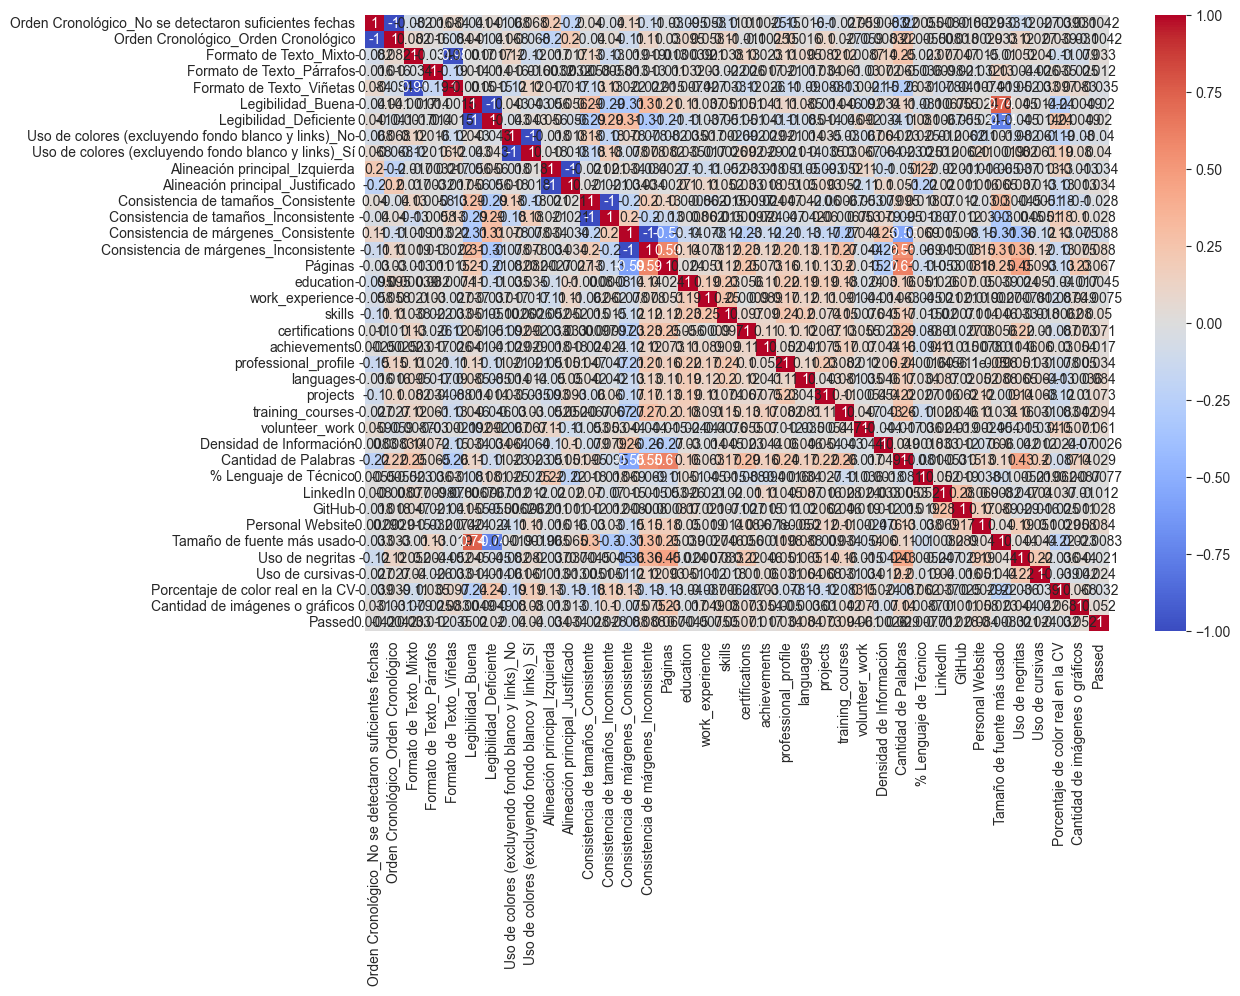

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(data_codificada.corr(), annot=True, cmap="coolwarm")
plt.show()

In [1]:
# Get correlation with "Passed" column
correlation_with_target = data_codificada.corr()["Passed"].drop("Passed")  # Remove self-correlation

# Sort features by absolute correlation value (strongest correlations first)
important_features = correlation_with_target.abs().sort_values(ascending=False)

# Display top 10 most important features
print("🔹 Top 15 Most Correlated Features with 'Passed':")
print(important_features.head(15))

NameError: name 'data_codificada' is not defined